## Αναλυση Εικονας Εργασια 2023-2024

Αιμιλιανός Κουρπάς-Δανάς Π20100 && Αναστάσιος Μελαχροινούδης Π20124


## Setup 

#### Library for the hypergraph.

In [7]:
!pip install hypernetx


#### Download a helper Function for the image view.

In [8]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py


--2024-02-06 19:57:54--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



#### Download the gdown

In [9]:
!pip install gdown


#### Libraries 

In [10]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder , Caltech101
import matplotlib.pyplot as plt
import numpy as np
import random
import gdown
import hypernetx as hnx
import tarfile
import os

print("Libraries and all the above are ready!")


Libraries and all the above are ready!


## Dataset 

Δεν μας αφησε να χρησημοποιησουμε την μεθοδο Caltech101 ,με πολλες προσπαθειες,οπότε με το gdown μπορεσαμε και τα κατεβασαμε manually. 

In [11]:
url = 'https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp'
output = '101_ObjectCategories.tar.gz'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=55e83e35-891e-4d9e-8b9e-fa6fd9979cdc
To: /Users/aa/image-analysis/101_ObjectCategories.tar.gz
100%|████████████████████████████████████████| 132M/132M [00:13<00:00, 10.1MB/s]


'101_ObjectCategories.tar.gz'

In [12]:
file_path = '/Users/aa/image-analysis/101_ObjectCategories.tar.gz'
extract_path = '/Users/aa/image-analysis/'

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(extract_path)

Ετοιμασία  κάποιον μετασχηματισμών ώστε οι εικόνες μας να μπορούν να δοθούν ως είσοδο στο νευρωνικο μας δίκτυο.
Και θα αποθηκευσουμε το μετασχημενο σύνολο δεδομενων στην μεταβλητή dataset.



In [13]:
# Define transformations if needed
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # adjust the size as needed
    transforms.ToTensor(),
])

# Create the dataset object
dataset = ImageFolder(root='/Users/aa/image-analysis/101_ObjectCategories', transform=transform)

In [14]:
len(dataset) #Length of our dataset


9144

θα περιορισουμε το dataset στις 3.500 εγραφες απο τις 9.144. 
Θα την μετατρεψουμε σε λιστα και θα κανουμε shuffle και μετα με την χρηση ενος slice θα κρατησουμε μονο 3.500.

In [15]:
dataset = list(dataset) #turn to list
random.shuffle(dataset) #shuffle the list
keep_number = 3500 #that how many records i want

dataset = dataset[:keep_number]  #keep_number length
len(dataset)

3500

Αφου εγινε αυτο πρεπει να χωριστουν τα labels με τις εικόνες.Αυτο πρεπει να γινει για την μετρηση της ακριβειας επειδη εκει θα χρησημοποιησουμε τα labels

In [16]:
images,labels = map(list, zip(*dataset))

<AxesSubplot: >

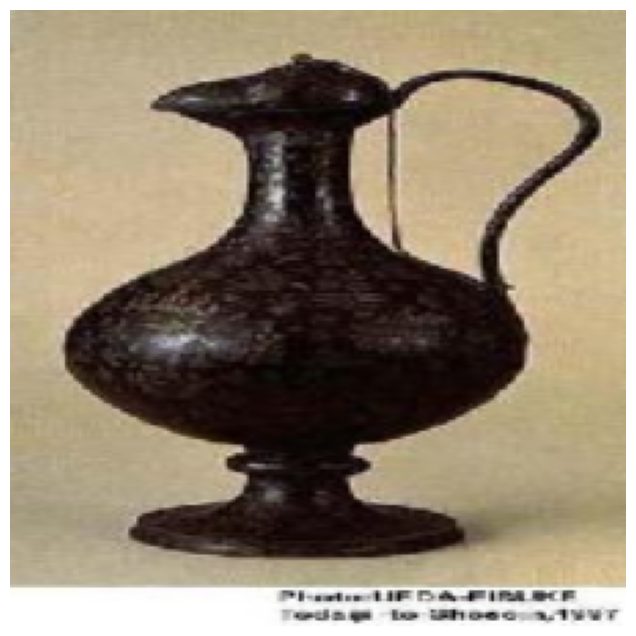

In [139]:
import helper
helper.imshow(images[1],normalize=False) #lets show the second picture


## Pretrain Model download and pretrain 

Φορτώνουμε ένα Vision Transformer από την PyTorch με προεκπαιδευμένα βάρη, τοποθετούμε στη GPU, παγώνουμε τα βάρη και τυπώνουμε τη δομή του δικτύου.

In [18]:
import timm

model = timm.create_model('vit_base_patch16_224', pretrained=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for param in model.parameters():
    param.requires_grad = False

print(model)



VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

Αντικατασταση του τελευταιου μοντελου με ενα αδειο Sequential layer για να παρουμε τα χαρακτηριστικα του. 

In [19]:
model.head = nn.Sequential()


Ας δουμε τις διαστασεις 

In [20]:
img = images[1] #get an image

features_var = model(img.unsqueeze(0).to(device))  #extract features
features = features_var.data

In [21]:
features.size()


torch.Size([1, 768])

## Algorithm

### Log-based Hypergraph of Ranking References (LHRR)


Initial similarity

Για την αρχική ομοιότητα εικόνων, χρησιμοποιούμε τον αντίστροφο της Ευκλείδειας απόστασης των feature vectors.

In [22]:
def similarity_lists(features):  #original similarity function
  '''
  Computes the euclidean distance between every pair of features.
  features = list of features extracted from each image
  '''
  T = [[(0,0) for i in range(len(features))] for j in range(len(features))]
  for i in range(len(features)):
    for j in range(i,len(features)):
      
      score = 1/(np.linalg.norm(features[i].cpu()-features[j].cpu())+0.00001) 
      #use the fact that euclidean distance is symmetrical to speed up computation (a-b)^2 = (b-a)^2
      T[i][j]=(score,j) 
      T[j][i]=(score,i) 
  return T

Rank normalization

In [23]:
def rank_normalization(features,T): # rank normalization
  '''
  Performs reciprocal rank normalization as defined in the paper 
  ρ_n(i,j) = 2L - (τ_i(j)+τ_j(i)),
  for each list τ in T, then sorts τ.

  features = list of features extracted from each image
  T = list of lists of distances
  '''
  L = len(features)
  for i in range(len(T)): #compute score for each pair
    for j in range(i,len(T)):
      score = 2*L - (T[i][j][0] + T[j][i][0])
      T[i][j] = (score,j)
      T[j][i] = (score,i)
  T = [sorted(t,key = lambda x: x[0]) for t in T]  #sort each sublist
  return T

Hyperedge construction

Δημιουργούμε υπερακμές, μια για κάθε εικόνα (σύνολο 2000), με κάθε υπερακμή να περιλαμβάνει τις k εικόνες με το χαμηλότερο distance από το Rank Normalization. Κάθε υπερακμή συνδέεται με την αντίστοιχη εικόνα, καλύπτοντας όλο το σύνολο των εικόνων.

In [24]:
def make_hyperedges(T,k): #make e_i
  '''
  Creates hyperedges as lists of nodes.
  Hyperedge e_i contains the first k nodes of T[i].

  T = list of sorted similarities for each pair of image features
  k = size of neighborhood
  '''
  E = []  
  for t in T: 
    temp = []
    for p in t[:k]: 
      temp.append(p[1]) 
    E.append(temp)
  return E 

Association/Incidence matrix


Δημιουργούμε τον πίνακα association με βάση τη διαφοροποίηση που εξηγήθηκε στην τάξη. Τα βάρη e_i-Vj εξαρτώνται από το αν η εικόνα Vj είναι στους πρώτους k γείτονες της εικόνας Vi. Η διαγώνιος αποτελείται από 1, τα υπόλοιπα βάρη μειώνονται σταδιακά, και αν η εικόνα Vj δεν είναι στους πρώτους k γείτονες, το βάρος είναι 0.

In [39]:
import math

def association(E,V,T,k):
  '''
  Creates the association/incidence matrix r(e_i,v_j)=h(e_i,v_j).
  Note: In our variation, since each hyperedge is centered around a node/image, it is clear that |E| = |V|. 
  Thus, the second parameter V can also be the list of hyperedges, since we only use its length. 

  E = list of hyperedges (each hyperedge is a list of nodes)
  V = list of nodes in the hypergraph
  T = list of sorted similarities for each pair of image features
  k = neighborhood size
  '''
  R = np.zeros((len(E),len(E)))
  for i,e in enumerate(E):  #for each edge
    for v in range(len(V)): #for each vertex
      if v in e:  #if vertex is in the hyperedge
        pos = e.index(v)+1  #get the position (+1 because counting in the paper starts from 1)
        R[i][v] = 1-math.log(pos,k+1)  #compute the weight
      else: #if vertex is not in the hyperedge
        R[i][v] = 0 #weight is 0
  return R


Hyperedge weights

Εδώ υπολογίζουμε τα βάρη των υπερακμών με βάση των τύπο στο paper.

In [26]:
def edge_weights(E,assoc):
  '''
  Computes edge weights as defined in page 6 of the paper.

  E = list of hyperedges
  assoc = association/incidence matrix H
  '''
  w = []
  for i,e in enumerate(E):  #for each hyperedge
    s=0
    for j in e: #for each node in the hyperedge
      s+= assoc[i][j]
    w.append(s)
  return w

Hyperedge similarities


Εδώ υπολογίζουμε το pairwise similarity matrix με βάση τον τύπο στο paper.



In [27]:
def hyperedge_similarities(assoc):  #Hyperedge Similarities
  '''
  Computes pairwise similarity matrix S as defined in page 6 of the paper.
  '''
  H = np.array(assoc)
  Sh = H @ H.T  # @ = matrix multiplication
  Su = H.T @ H
  S = np.multiply(Sh,Su)  # Hadamard product
  return S

Membership degrees

Εδώ υπολογίζουμε τα membership degrees όπως και το paper. Αρχικά ορίζουμε και μια βοηθητική συνάρτηση που κατασκευάζει το καρτεσιανό γινόμενο μεταξύ 2 υπερακμών.

In [28]:
def cartesian_product(eq,ei):
  '''
  Creates the cartesian product of 2 hyperedges (lists of nodes)

  eq, ei = hyperedges
  '''
  return np.transpose([np.tile(eq, len(ei)), np.repeat(eq, len(ei))])

def pairwise_similarity_relationship(w,assoc,E):
  '''
  Computes pairwise similarity relationship / membership degrees as defined in page 6 of the paper.

  w = hyperedge weights
  assoc = incidence/association matrix
  E = list of hyperedges
  '''

  # v_i, v_j in e_q^2 (cartesian product)
  #p(e_q,v_i,v_j) = |E| x |e_q^2| 
  
  p = [{} for _ in range(len(E))] #for each hyperedge create a dictionary with node pairs as keys
  for i,e in enumerate(E):
    cp3 = cartesian_product(e,e)
    for (v1,v2) in cp3:
      p[i][(v1,v2)] = w[i]*assoc[i][v1]*assoc[i][v2]
  return p

Similarity based on the cartesian product.

In [29]:
def make_C(E,p):
  '''
  Computes the similarity based on the cartesian product (page 6).

  E = list of hyperedges
  p = list of membership degrees for each pair in each hyperedge
  '''
  C = np.zeros((len(E),len(E)))
  for i,e in enumerate(E):  #for each hyperedge
    for (v1,v2) in p[i]:  #for each pair in the dict
      C[v1][v2]+=p[i][(v1,v2)]  #compute value
  return C

Affinity matrix

In [30]:
def affinity_matrix(C,S):
  '''
  Computes final affinity matrix (page 6)
  '''
  return np.multiply(C,S)

ALL TOGETHER


In [31]:
def LHRR(features,init_lists,k=3,num_iters=10):
  '''
  Entire LHRR algorithm put together

  features = list of features extracted from each image
  init_lists = initial similarity lists based on euclidean distance
  k = neighborhood size / hyperedge size
  num_iters = for how many iterations the algorithm will run
  '''

  for i in range(num_iters):

    T = rank_normalization(features,init_lists)  #perform rank normalization

    E = make_hyperedges(T,k)  #make hyperedges

    #HG = make_hypergraph(E)  #make hypergraph

    assoc = association(E,E,T,k)  #make association/incidence matrix 
    #There is an explanation above as to why E is passed two times

    w = edge_weights(E,assoc) #compute edge weights

    S = hyperedge_similarities(assoc) #compute hyper-edge similarities

    p = pairwise_similarity_relationship(w,assoc,E) #compute pairwise relationships

    C = make_C(E,p) #make the cartesian product based similarity matrix

    aff = affinity_matrix(C,S)  #compute the final matrix W

    # reshape final matrix so it becomes input of the next iteration
    aff = aff.tolist()

    for i,row in enumerate(aff):
      for j,v in enumerate(row):
        aff[i][j] = (aff[i][j],j) #add information about the index

    T = aff
  return aff

## Runing the algorithm 

Εξαγωγη των χαρακτηριστικών με το νευρωνικο δικτυο.

In [32]:
features = []

for img in images:
  features.append(model(img.unsqueeze(0).to(device))) 


print(len(features))

3500


Αρχικές λίστες με τις αντίστροφες Ευκλείδιες αποστάσεις τις υπολογίζουμε εκτός του αλγορίθμου.

In [33]:
init_lists = similarity_lists(features)


Τρεχουμε τον αλγοριθμο

In [40]:
final_ranking = LHRR(features,init_lists,k=3,num_iters=3)  #final matrix W


/var/folders/jx/r1xmcxgx6r7_h4ldbm4_tfbr0000gn/T/ipykernel_39867/2550514448.py:6: RuntimeWarning: invalid value encountered in matmul
  Sh = H @ H.T  # @ = matrix multiplication
/var/folders/jx/r1xmcxgx6r7_h4ldbm4_tfbr0000gn/T/ipykernel_39867/2550514448.py:7: RuntimeWarning: invalid value encountered in matmul
  Su = H.T @ H


## Visualize examples

Θα παρουμε παραδειγμα την 2η εικονα.

In [140]:
query_index = 1 #second image
retrieved = []  #keep indexes and scores of relevant images here
for (score,i) in final_ranking[query_index]:  #search first row of W
  if score!=0:  #if score is non zero
    retrieved.append((score,i))
retrieved = sorted(retrieved,key = lambda x: x[0],reverse=True) #sort by score

print(retrieved)

[(2.402190537018941, 1), (0.23182300398972688, 3078), (0.015259401746890366, 221), (0.015259401746890366, 800)]


In [83]:
for (score,i) in retrieved[1:]:
  print(score,i)

1.707518749639422 1687
0.015259401746890366 1913


Στην παραπάνω λίστα φαινόνται τα ζευγάρια (retrieved image score, retrieved image index). Προφανώς για την εικόνα 0 μεγαλύτερο σκορ έχει η ίδια η εικόνα 0. 

<AxesSubplot: >

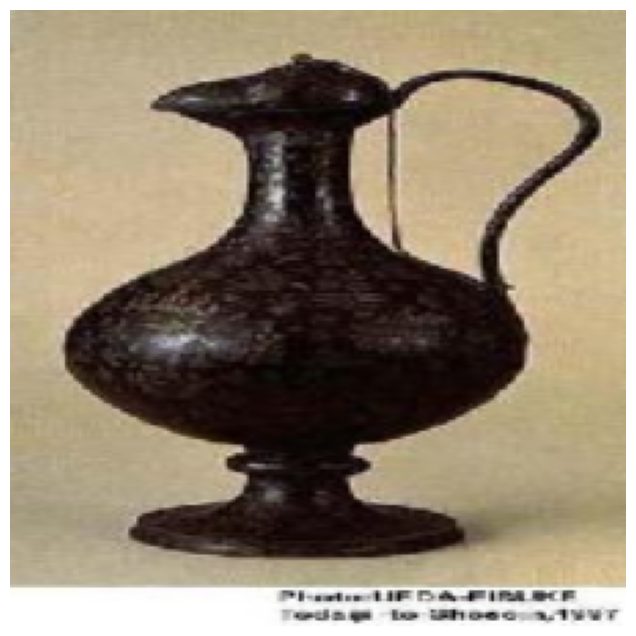

In [141]:
helper.imshow(images[1],normalize=False)


<AxesSubplot: >

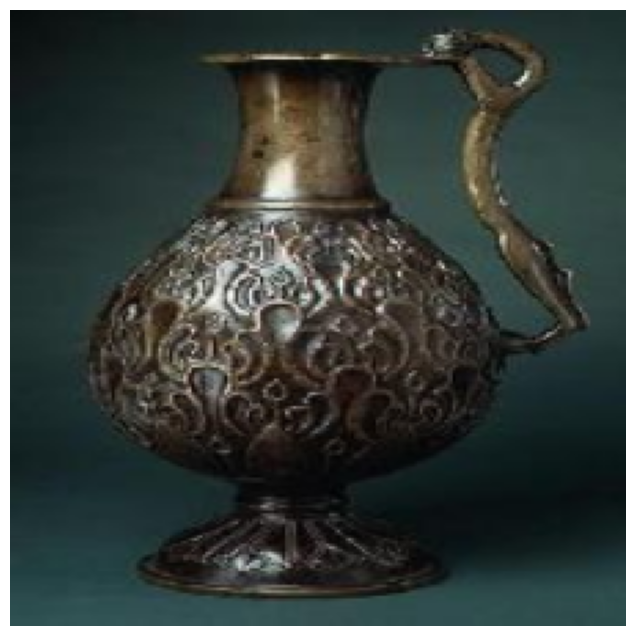

In [142]:
helper.imshow(images[3078],normalize=False)


<AxesSubplot: >

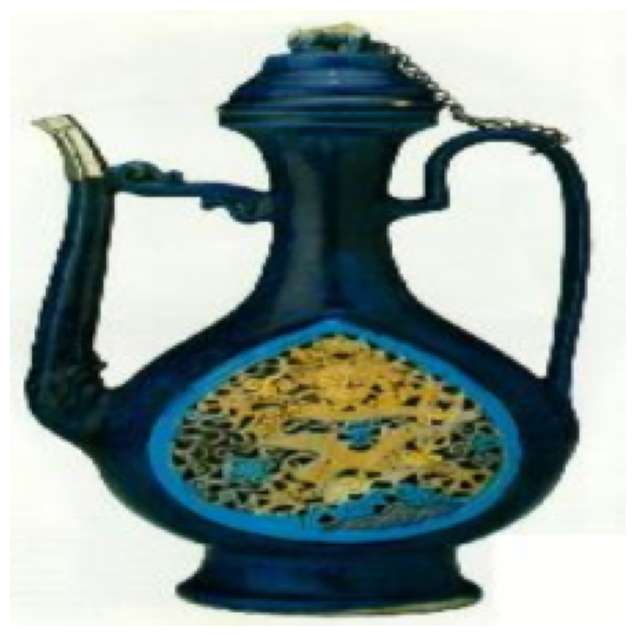

In [143]:
helper.imshow(images[221],normalize=False)


<AxesSubplot: >

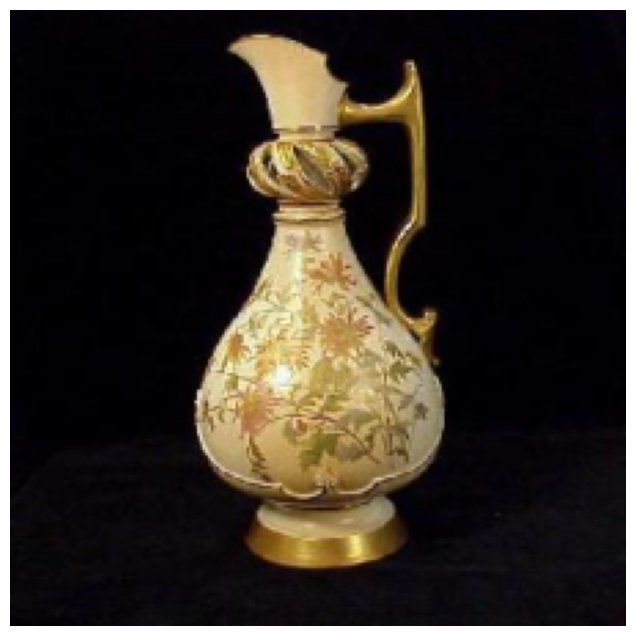

In [144]:
helper.imshow(images[800],normalize=False)


Παρατηρουμε οτι μοιαζουν μεταξυ τους

## Accuracy

Xρησιμοποιούμε precision και recall για να εκτιμήσουμε την ακρίβεια του αλγορίθμου. Δύο εικόνες θεωρούνται relevant/similar αν έχουν το ίδιο label. 

In [59]:
def precision(query_index, final_ranking, labels, k=5):
    '''
    Compute precision using labels.

    query_index: Index of the query image.
    final_ranking: Affinity matrix W with final results.
    labels: Image labels.
    k: Number of retrieved images to keep.
    '''

    retrieved = [(score, i) for score, i in final_ranking[query_index] if score != 0]
    retrieved = sorted(retrieved, key=lambda x: x[0], reverse=True)[1:k+1]

    true_label = labels[query_index]
    correct_count = sum(1 for _, ix in retrieved if labels[ix] == true_label)

    return correct_count / len(retrieved)


In [145]:
q_img = 8
p = precision(q_img,final_ranking,labels)
print("Precision for image "+str(q_img)+" is:",p)

Precision for image 8 is: 1.0


In [61]:
print("Query label: ",labels[1])


Query label:  40


In [62]:
print("Retrieved image #1 label: ",labels[1356])


Retrieved image #1 label:  76


In [63]:
print("Retrieved image #1 label: ",labels[2716])


Retrieved image #1 label:  6


Αρα για αυτο βγηκε Precision 1.0 γιατι και τα 3 labels ειναι ιδια.

In [64]:
def recall(query_index, final_ranking, labels):
    ixs = [i for score, i in final_ranking[query_index] if score != 0]
    ixs.sort(reverse=True)

    true_label = labels[query_index]
    correct_count = sum(1 for ix in ixs[1:] if labels[ix] == true_label)

    db_count = labels.count(true_label)
    
    return correct_count / (db_count - 1) if db_count > 1 else 0


In [146]:
q_img = 8
r = recall(q_img,final_ranking,labels)
print("Recall for image "+str(q_img)+" is:",r)

Recall for image 8 is: 0.23529411764705882


Τελος jupyter notebook.